In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sklearn.decomposition, sklearn.cluster
from nheatmap import nhm, scripts
import matplotlib.pyplot as plt
import matplotlib as mpl
import scanpy as sc

# create a color dictionary for tissues
def tissue_colors():
    
    tissue_color_dict = {'Bladder': '#e7969c',
             'Blood': '#d6616b',
             'Bone_Marrow': '#cedb9c',
             'Eye': '#c7ea46',#"#00ff7f",
             'Fat': '#e7cb94',
             'Heart': '#ff0800',
             'Kidney': '#7b4173',
             'Large_Intestine': '#31a354',
             'Liver': '#000080',
             'Lung': '#3182bd',
             'Lymph_Node': '#8c6d31',
             'Mammary':'#ce6dbd',
             'Muscle': '#e7ba52',
             'Pancreas': '#fd8d3c',
             'Prostate':'#637939',#'#a55194',#
             'Salivary_Gland':'#622a0f',
             'Skin': '#de9ed6',
             'Small_Intestine': '#6baed6',
             'Spleen': '#393b79',
             'Thymus': '#9c9ede',
             'Tongue':'#b5cf6b',
             'Trachea': '#969696',
             'Uterus':'#c64b8c',#'#ff0090',
             'Vasculature': '#843c39'}
    
    return tissue_color_dict

In [2]:
cell_type = 'macrophage'
adata = sc.read_h5ad('../../data/TSP1_TSP15_scvi_donor-method_normalized-log1p-scaled_annotated.h5ad', backed='r+')                                                                                       
adata = adata[adata.obs.cell_ontology_class == cell_type]

adata = adata.to_memory()
adata = adata[~adata.obs.tissue.isin(['Salivary_Gland', 'Heart', 'Eye', 'Fat'])]
gene_set = pd.read_csv("../immune_signatures/macrophagetissue_distinguishing_genes.csv")
subset = False
if subset:
    adata = adata[:,adata.var.index.isin(gene_set.iloc[:,0])]

def _pp(adata, log, normalize, remove_dissociation):
    if normalize:
        sc.pp.normalize_total(adata)
    if log:
        sc.pp.log1p(adata, chunk_size=50000)
        adata.raw = adata
    if remove_dissociation:
    #mouse2human = pd.read_csv('../metadata/mouse2human.csv')
        dissociation_genes = pd.read_csv('../metadata/Mouse2Human_dissociation_genes.csv')
        adata.var['not_dissociation_gene'] = ~adata.var.index.isin(dissociation_genes['Human gene name'])
        adata = adata[:, adata.var.not_dissociation_gene == True]
    highly_variable = False
    sc.pp.highly_variable_genes(adata, n_top_genes=1000)

    if highly_variable:
        adata = adata[:,adata.var.highly_variable == True]

    return adata

adata = _pp(adata, True, True, False)

/home/michaelswift/miniconda3/envs/scirpy/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [3]:
# set up nheatmap matrices
df = sc.get.obs_df(adata)

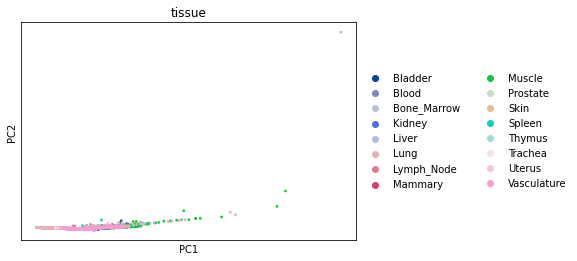

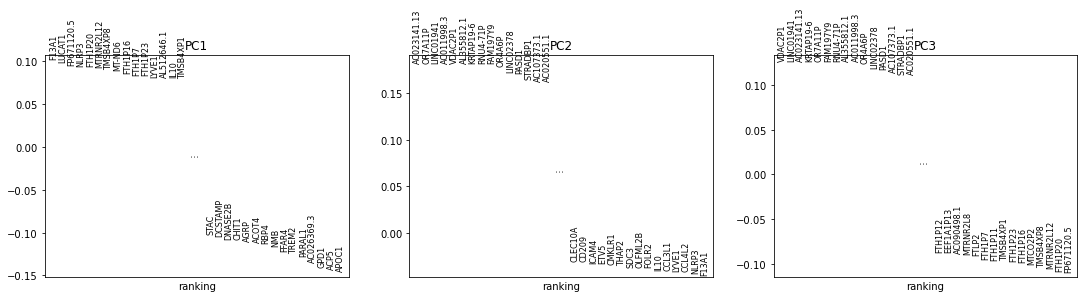

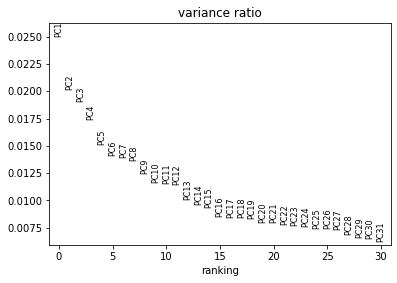

In [4]:
sc.pp.scale(adata)

sc.pp.pca(adata)

sc.pl.pca_overview(adata, color = ['tissue'], projection = '2d', size = 30)

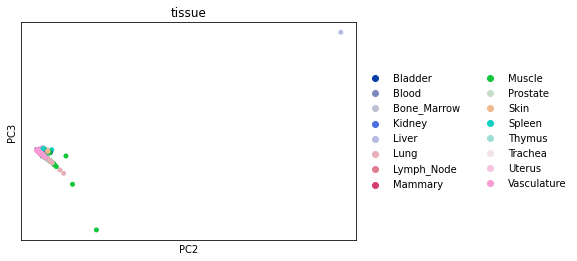

In [5]:
sc.pl.pca(adata, components=[2,3], color='tissue', size = 100)

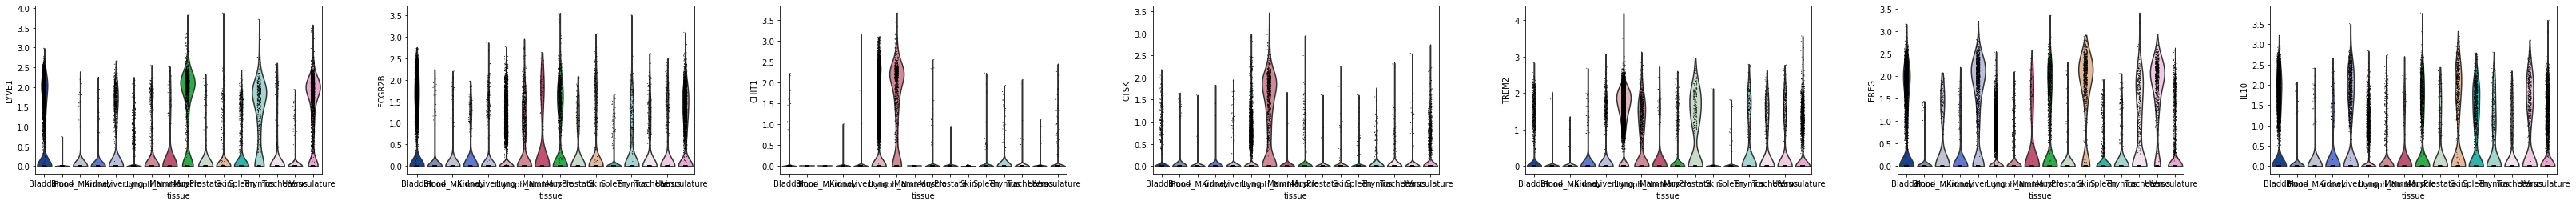

In [7]:
sc.pl.violin(adata, keys=['LYVE1','FCGR2B', 'CHIT1', 'CTSK', 'TREM2', 
                         'EREG', 'IL10'], groupby='tissue')

In [8]:
adata

AnnData object with n_obs × n_vars = 32125 × 58870
    obs: '10X_run', 'pilot', 'tissue', 'subtissue', 'method', '10X_sample', '10X_replicate', 'notes', 'seqrun', 'donor', 'anatomical_position', '10X_barcode', 'cDNAplate', 'libraryplate', 'well', 'donor_method', 'cell_identifier', 'decontX_split', 'n_counts', 'n_genes', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', '_dataset', 'knn_on_bbknn_pred', 'knn_on_scanorama_pred', 'Annotation', '_labels_annotation', 'scanvi_offline_pred', 'svm_pred', 'final_annotation_cell_ontology_id', 'onclass_pred', 'rf_pred', '_batch_annotation', 'knn_on_scvi_offline_pred', 'consensus_percentage', 'consensus_prediction', 'Manually Annotated', '_ref_subsample', 'score_epithelial', 'score_endothelial', 'score_stromal', 'score_immune', 'computational_compartment_assignment', 'tissue_cell_type', 'cell_type_tissue', 'cell_ontology_class', 'free_annotation', 'manually_annotated'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'hig

In [10]:
sc.tl.rank_genes_groups(adata, groupby='tissue', use_raw = False, layer = 'decontXcounts')

/home/michaelswift/miniconda3/envs/scirpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:416: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:416: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


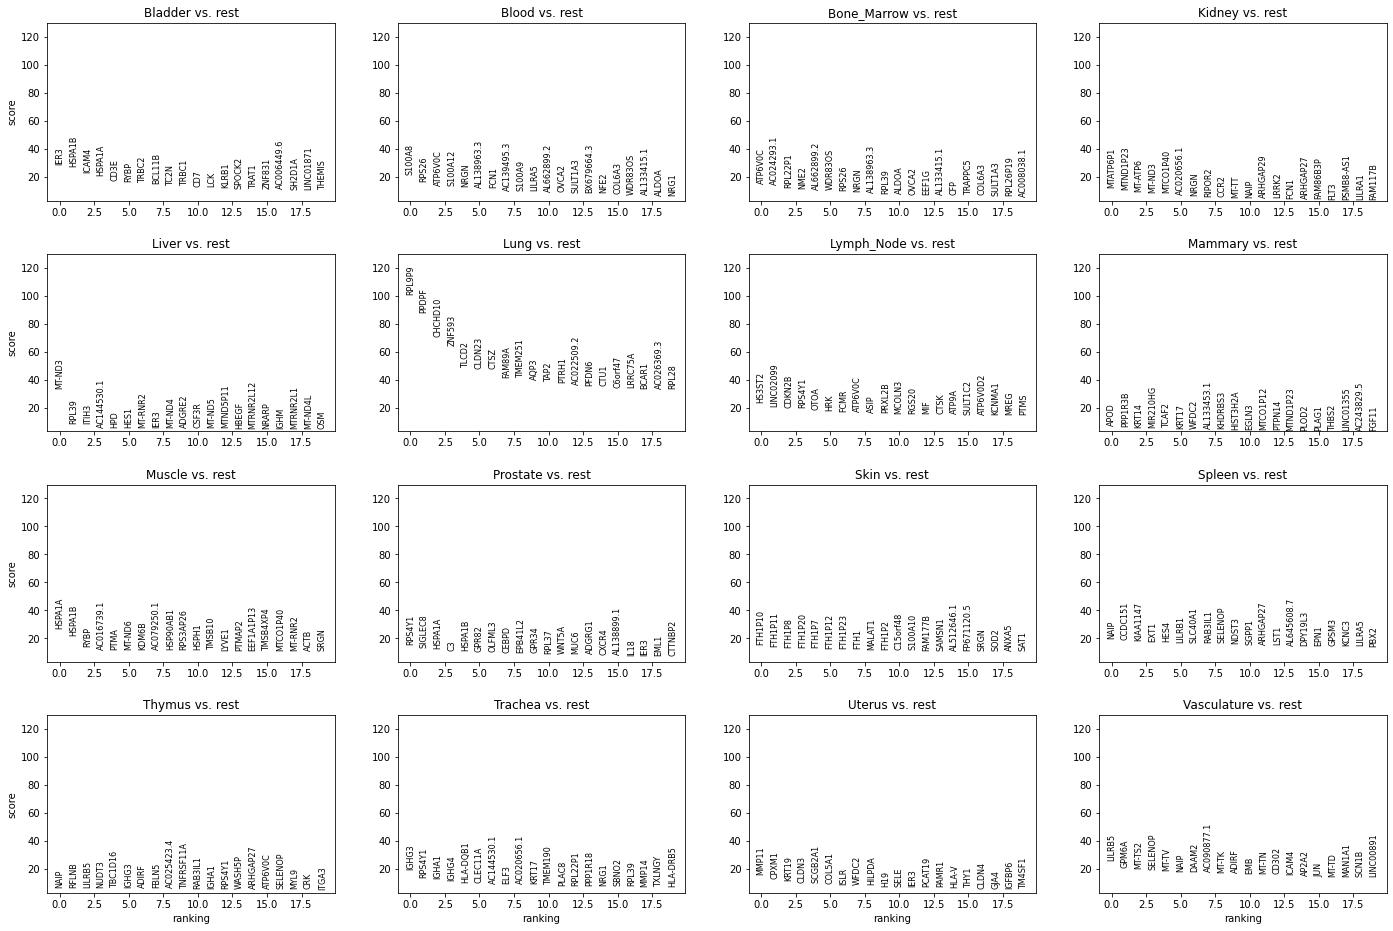

In [12]:
sc.pl.rank_genes_groups(adata)

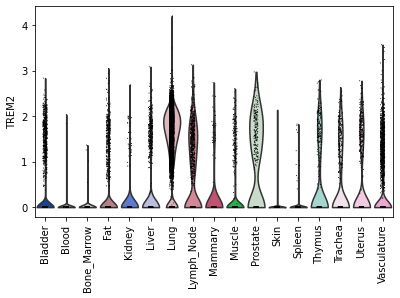

In [22]:
sc.pl.violin(adata, keys=['TREM2'], groupby='tissue', rotation=90)

Trying to set attribute `.uns` of view, copying.


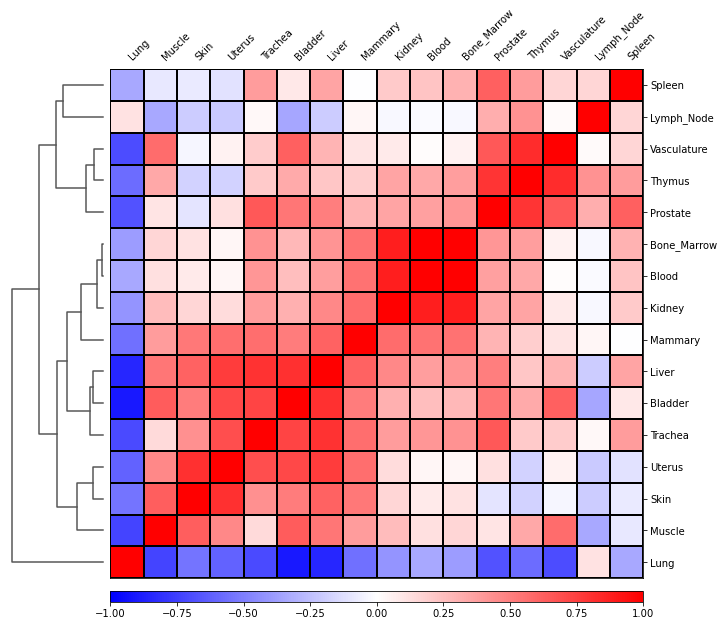

In [13]:
sc.pl.correlation_matrix(adata[:,adata.var.highly_variable == True], groupby='tissue')

In [ ]:
sc.pl.correlation_matrix(adata[:,adata.var.highly_variable == True], groupby='tissue', save='naive_tissue_macrophage')

#### 

In [14]:
dfr = sc.get.obs_df(
                adata,
                keys=['tissue'])

pc1 = adata.obsm['X_pca'][:,0]
pc2 = adata.obsm['X_pca'][:,1]
pc3 = adata.obsm['X_pca'][:,2]

dfr['PC1'], dfr["PC2"], dfr["PC3"] = pc1, pc2, pc3

In [15]:
gene_PC1_score = adata.varm['PCs'][:,0]
gene_PC2_score = adata.varm['PCs'][:,1]
gene_PC3_score = adata.varm['PCs'][:,2]

In [16]:
dfc = sc.get.var_df(
                adata,
                keys=['highly_variable'])

In [17]:
dfc['PC1_load'], dfc["PC2_load"], dfc["PC3_load"] = adata.varm['PCs'][:,0], adata.varm['PCs'][:,1], adata.varm['PCs'][:,2]

In [18]:
adata

AnnData object with n_obs × n_vars = 32125 × 58870
    obs: '10X_run', 'pilot', 'tissue', 'subtissue', 'method', '10X_sample', '10X_replicate', 'notes', 'seqrun', 'donor', 'anatomical_position', '10X_barcode', 'cDNAplate', 'libraryplate', 'well', 'donor_method', 'cell_identifier', 'decontX_split', 'n_counts', 'n_genes', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', '_dataset', 'knn_on_bbknn_pred', 'knn_on_scanorama_pred', 'Annotation', '_labels_annotation', 'scanvi_offline_pred', 'svm_pred', 'final_annotation_cell_ontology_id', 'onclass_pred', 'rf_pred', '_batch_annotation', 'knn_on_scvi_offline_pred', 'consensus_percentage', 'consensus_prediction', 'Manually Annotated', '_ref_subsample', 'score_epithelial', 'score_endothelial', 'score_stromal', 'score_immune', 'computational_compartment_assignment', 'tissue_cell_type', 'cell_type_tissue', 'cell_ontology_class', 'free_annotation', 'manually_annotated'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'hig

In [19]:
hvgs = adata.var[adata.var.highly_variable == True].index.to_list()
df = sc.get.obs_df(adata)

In [20]:
df = pd.DataFrame(adata.raw.X.toarray())

In [ ]:
df.head()

In [21]:
df.index = adata.obs.index
df.columns = adata.var.index

In [ ]:
#cmaps={'PC1':'RdYlGn', 'gene cluster':'inferno',
        'PC1_load':'gist_heat', 'PC2_load':'rainbow'}

In [22]:
g = nhm(data=df, dfr=dfr, dfc=dfc, figsize=(10, 10), showxticks=True)

In [ ]:
fig, plots = g.run()
